In [1]:
# Reference: https://jupyterbook.org/interactive/hiding.html
# Use {hide, remove}-{input, output, cell} tags to hiding content

import sys
import os
if not any(path.endswith('textbook') for path in sys.path):
    sys.path.append(os.path.abspath('../../..'))
from textbook_utils import *

# Basics of Prediction Intervals



Confidence intervals convey the accuracy of an estimator, but sometimes we want the accuracy of a prediction for a future observation. For example, someone might say: half the time my bus arrives at most 3/4 of a minute late, but how late might it get? As another example, the California Department of Fish and Game sets the minimum catch size for Dungeness crabs at 146 mm, and a recreational fishing company might wonder how much bigger than 146 mm their customer's catch might be when they bring them fishing. And for another example, a vet estimates the weight of a donkey to be 169 kg based on its length and girth and uses this estimate to administer medication. For the donkey's safety, the vet is keen to know how different the donkey's real weight might be from this estimate.  

What these examples have in common is an interest in the prediction of a future observation, and the desire to quantify how far that future observation might be from this prediction. Just like with confidence intervals, we compute the statistic (the estimator) and use it in making the prediction,
but now we're interested in typical deviations of future observations from the prediction. 
In the following sections, we work through examples of prediction intervals based on quantiles, standard deviations, and those conditional on covariates. Along the way, we provide additional information about the typical variation of observations about a prediction.  

## Example: Predicting Bus Lateness 

{numref}`Chapter %s <ch:modeling>` models the lateness of a Seattle bus in arriving at a particular stop. We observed that the distribution was highly skewed and chose to estimate the typical lateness by the median, which was 0.74 minutes. We reproduce the sample histogram from that chapter here.

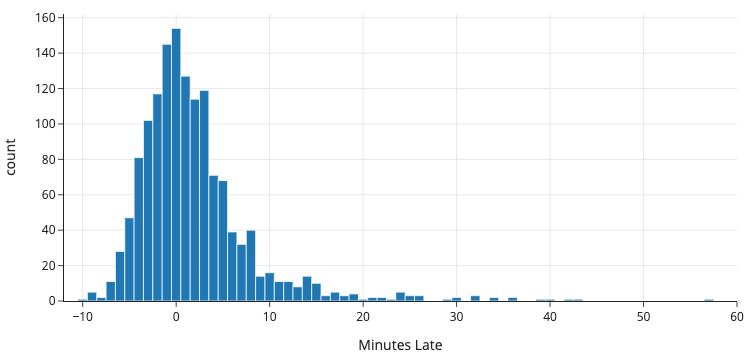

In [2]:
times = pd.read_csv('data/seattle_bus_times_NC.csv')
fig = px.histogram(times, x='minutes_late', width=350, height=250)
fig.update_xaxes(range=[-12, 60], title_text='Minutes Late')
fig

The prediction problem addresses how late a bus might be. While the median is informative, it doesn't provide information about the skewness of the distribution. That is, we don't know how late the bus might be. The 75th percentile, or even the 95th percentile, would add useful information to consider. We compute them here:

In [3]:
print(f"median:  {times['minutes_late'].median():.2f} mins late")
print(f"75th percentile:  {np.percentile(times['minutes_late'], 75.0, interpolation='lower'):.2f} mins late")
print(f"95th percentile:  {np.percentile(times['minutes_late'], 95.0, interpolation='lower'):.2f} mins late")

median:  0.74 mins late
75th percentile:  3.78 mins late
95th percentile:  13.02 mins late


From these statistics, we learn that while more than half the time the bus is not even a minute late, another quarter of the time it's up to almost four minutes late, and with some regularity it can happen that the bus is nearly a quarter of an hour late. These three values together help us make plans.

## Example: Predicting Crab Size

Fishing for Dungeness crabs is highly regulated, including limiting the shell size to 146 mm in width for crabs caught for recreation. To better understand the distribution of shell size of Dungeness crabs, the California Department of Fish and Game worked with commercial crab fishers from northern California and southern Oregon to capture, measure, and release crabs. Below is a histogram of crab shell sizes for the approximately 450 crabs caught.    

In [5]:
def subset_and_rename_A(df):
    df = df[['presz', 'inc']]
    df.columns = ['shell', 'inc'] 
    return df

crabs = (pd.read_csv('data/crabs.data', delimiter='\s+')
         .query('inc > 8')
         .query('presz > 100')
         .pipe(subset_and_rename_A)
        )

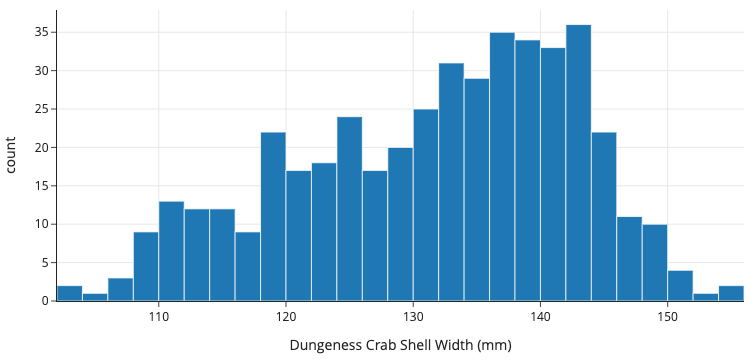

In [8]:
px.histogram(crabs, x='shell', nbins=50,
             labels=dict(shell='Dungeness Crab Shell Width (mm)'),
             width=350, height=250)

The distribution is somewhat skewed left, but the average and standard deviation are reasonably summary statistics of the distribution. 

In [14]:
crabs['shell'].describe()

count    452.00
mean     131.53
std       11.07
          ...  
50%      133.30
75%      140.30
max      155.10
Name: shell, Length: 8, dtype: float64

The average, 132 mm, is a good prediction for the typical size of crab. However, it lacks information about how far an individual crab may vary from the average. The standard deviation can fill in this gap.

In addition to the variability of individual observations about the center of the distribution, we also take into account the variability in our estimate of the mean shell size. We can use the bootstrap to estimate this variability or we can use probability theory (we do this in the next section) to show that the standard deviation of the estimator is $SD(pop)/\sqrt{n}$.
Also, in the next section, we show that these two sources of variation combine as follows:

$$
\sqrt{SD(pop)^2 + \frac {SD(pop)^2}{n}} ~=~ SD(pop) \sqrt{1 + \frac {1}{n}}
$$

We substitute $SD(sample)$ in for $SD(pop)$ and apply this formula to our crabs: 

In [10]:
np.std(crabs['shell']) * np.sqrt(1 + 1/len(crabs))

11.073329460297957

We see that including the SE(sample average) essentially doesn't change the prediction error because the sample is so large. We conclude that crabs routinely differ from the typical size of 132 mm by 11 to 22 mm. This information is helpful in developing policies around crab fishing to maintain the health of the crab population and to set expectations for the recreational fisher. 

## Example: Predicting the incremental growth of a crab

After Dungeness crabs mature, they continue to grow by casting off their shell and building a new larger one to grow into each year; this process is called molting. The California Department of Fish and Game, wanted a better understanding of crab growth so they could set better limits on fishing that would protect the crab population. The crabs caught in the study mentioned in the previous example were about to molt, and in addition to measuring their size, the change in shell size from before to after molting was also recorded. 

In [15]:
crabs.corr()

,shell,inc
shell,1.0,-0.6
inc,-0.6,1.0


These two measurements are negatively correlated, meaning that the larger the crab, the less they grow when they molt. We plot the growth increment against the shell size to determine whether the relationship between these variables is roughly linear.   

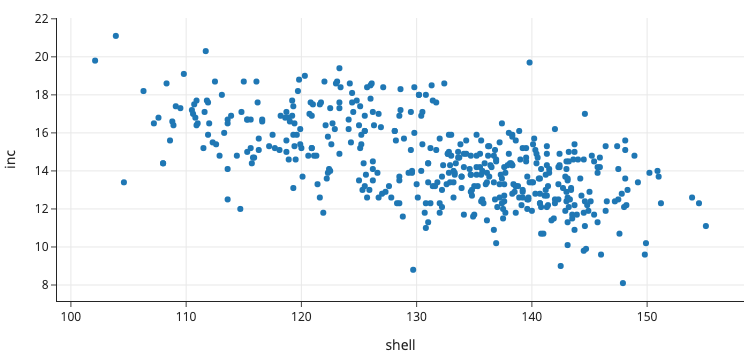

In [16]:
px.scatter(crabs, y='inc', x= 'shell', 
           width=350, height=250)

The relationship appears linear, and we can fit a simple linear model to explain the growth  increment by the pre-molt size of the shell. For this example, we use the `statsmodels` library, which provides prediction intervals with `get_prediction`. We first set up the design matrix and response variable, and then we use least squares to fit the model.

In [17]:
import statsmodels.api as sm

In [18]:
y = crabs['inc']
X = crabs[['shell']]
X = sm.add_constant(X)

In [20]:
inc_model = sm.OLS(y, X).fit()

print(f"Intercept: {inc_model.params[0]:0.2f}", 
      f"\nSlope: {inc_model.params[1]:0.2f}")

Intercept: 29.80 
Slope: -0.12


When modeling, we create prediction intervals for given values of the explanatory variable.  For example, if a newly caught crab is 120 mm across, then we use our fitted model to predict its shell's growth:

$$
29.8 ~-~ (0.12 \times 120) ~\approx~ 15.4 
$$

As in the previous example, the variability of our prediction for an individual observation, includes the variability in our estimate of the crab's growth and the crab-to-crab variation in shell size. Again, we can use the bootstrap to estimate this variation, or we can use probability theory to show that these two sources of variation combine as follows:

$$
SD(\mathbf{e}) \sqrt{1 + \mathbf{x}_0 (\textbf{X}^\top \textbf{X})^{-1}\mathbf{x}_0^\top} 
$$

Here $\textbf{X}$ is the design matrix that consists of the original data, $\mathbf{e}$ is the $n \times 1$ column vector of residuals from the regression, and $\mathbf{x}_0$ is the $1 \times (p + 1)$ row vector of features for the new observation (in this example, these are $\left[1, 120\right]$):

In [24]:
new_data = dict(const=1, shell=120)
new_X = pd.DataFrame(new_data, index=[0])
new_X

,const,shell
0,1,120


We use the `get_prediction` method in `statsmodels` to find a 95% prediction interval for a crab with a 120 mm shell: 

In [26]:
pred = inc_model.get_prediction(new_X)

pred.summary_frame(alpha=0.05)

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,15.86,0.12,15.63,16.08,12.48,19.24


Here we have both a confidence interval for the average growth increment for a crab with a 120 mm shell, \[15.6, 16.1\], and a prediction interval for the growth increment, \[12.5, 19.2\] .   The prediction interval is quite a bit wider because it takes into account the variation in individual crabs. This variation is seen in the spread of the points around the regression line, which we approximate by the SD of the residuals. The correlation between shell size and growth increment means that the variation in growth increment around the prediction is smaller than the overall SD of growth increment. 

In [27]:
print(f"Residual SD: {np.std(inc_model.resid):0.2f}\n",
     f"Crab growth SD: {np.std(crabs['inc']):0.2f}")

Residual SD: 1.71
 Crab growth SD: 2.14


The intervals provided by `get_prediction` rely on the normal approximation to the distribution of growth increment. That's why the 95% prediction interval endpoints are roughly twice the residual SD away from the prediction. In the next section, we dive more deeply into these calculations of standard deviations, estimators, and predictions. And we discuss some of the assumptions that we make in calculating them.  